# Functional Annotation Analysis

In [436]:
import copy
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
import urllib2
import zlib
from StringIO import StringIO

def read_gzipped_text_url(url):
    """Read a gzipped text file from a URL and return 
    contents as a string."""
    # Create a opener
    opener = urllib2.build_opener() 

    request = urllib2.Request(url)
    request.add_header('Accept-encoding', 'gzip')

    # Fetch the gzip filer
    respond = opener.open(request)
    compressedData = respond.read()
    respond.close()

    opener.close()

    # Extract data and save to text file
    compressedDataBuf = StringIO(compressedData)
    d = zlib.decompressobj(16+zlib.MAX_WBITS)

    buffer = compressedDataBuf.read(1024)
    #saveFile = open('/tmp/test.txt', "wb")
    s = []
    while buffer:
        s.append(d.decompress(buffer))
        buffer = compressedDataBuf.read(1024)
    s = ''.join(s)
    return s

In [5]:
if socket.gethostname() == 'fl1':
    pbt.set_tempdir('/projects/cdeboever/pybedtools_temp')

In [6]:
outdir = os.path.join(ciepy.root, 'output',
                      'functional_annotation_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'functional_annotation_analysis')
cpy.makedir(private_outdir)

In [7]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.columns = ['{}_gene'.format(x) for x in qvalues.columns]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

In [8]:
state_annot = pd.read_table(os.path.join(cpy.roadmap_15_state, 
                                         'frazer_annotation.tsv'))
state_annot['NAME'] = ((state_annot.index + 1).astype(str) + '_' + 
                       state_annot.MNEMONIC)
roadmap_ids = pd.read_table(os.path.join(cpy.roadmap_15_state, 
                                         'EIDlegend.txt'),
                            index_col=0, header=None, squeeze=True)

/raid/development/cdeboever/software/anaconda1.9.1/envs/cardips/lib/python2.7/site-packages/pandas/core/index.py:1338: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  "use '|' or .union()", FutureWarning)


In [9]:
most_sig = most_sig.join(qvalues)
sig = most_sig[most_sig.sig_gene]

In [10]:
# Make be file for most sig SNVs.
s = (sig.chrom + '\t' + (sig.coord - 1).astype(int).astype(str) + 
     '\t' + sig.coord.astype(int).astype(str))
snvs = pbt.BedTool('\n'.join(s) + '\n', from_string=True)
snvs = snvs.sort()

# Get intergenic SNVs.
intergenic_snvs = snvs.intersect(genes, v=True)

# 5kb window centered on SNVs.
intergenic_window = intergenic_snvs.slop(l=2500, r=2500, g=pbt.genome_registry.hg19).merge()

## Roadmap Chromatin States

In [12]:
def calc_state_enrichment(fn):
    """Calculate enrichments for a Roadmap chromatin state
    bed file"""
    bt = pbt.BedTool(fn)
    res = intergenic_snvs.intersect(bt, sorted=True, wo=True)
    real = pd.Series(0, index=state_annot.NAME)
    for r in res:
        real[r.fields[-2]] += int(r.fields[-1])

    res = intergenic_window.intersect(bt, sorted=True, wo=True)
    background = pd.Series(0, index=state_annot.NAME)
    for r in res:
        background[r.fields[-2]] += int(r.fields[-1])
    df = pd.DataFrame(0, index=real.index, columns=['oddsratio', 'pvalue'])
    for i in real.index:
        in_eqtl = real[i]
        in_not_eqtl = background[i] - in_eqtl
        out_eqtl = real.sum() - in_eqtl
        out_not_eqtl = background.sum() - background[i] - out_eqtl
        oddsratio, p = fisher_exact([[in_eqtl, in_not_eqtl],
                                     [out_eqtl, out_not_eqtl]])
        df.ix[i] = [oddsratio, p]
    return df

In [488]:
a = os.path.join(outdir, 'state_pvalues.tsv')
b = os.path.join(outdir, 'state_oddsratios.tsv')
if sum([os.path.exists(x) for x in [a, b]]) != 2:
    beds = glob.glob(os.path.join(cpy.roadmap_15_state, '*bed'))
    enrichments = {}

    for fn in beds:
        enrichments[os.path.split(fn)[1].split('_')[0]] = calc_state_enrichment(fn)
    p = pd.Panel(enrichments)
    state_oddsratios = p.ix[:, :, 'oddsratio'].T
    state_oddsratios.to_csv(b, sep='\t')
    state_pvalues = p.ix[:, :, 'pvalue'].T
    state_pvalues.to_csv(a, sep='\t')
else:
    state_pvalues = pd.read_table(a, index_col=0)
    state_oddsratios = pd.read_table(b, index_col=0)
    
state_oddsratios.index = roadmap_ids[state_oddsratios.index]
state_pvalues.index = roadmap_ids[state_pvalues.index]

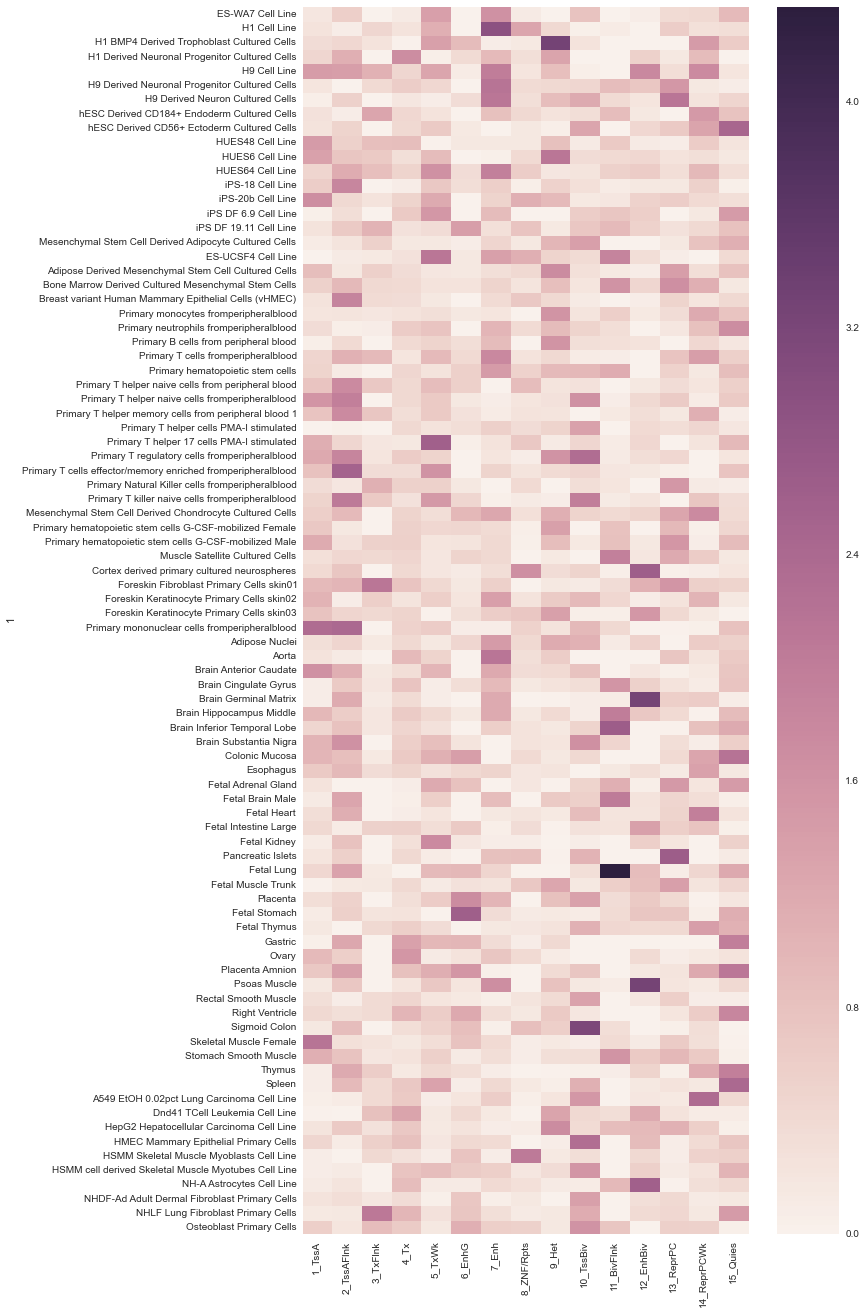

In [489]:
t = state_pvalues[state_pvalues.apply(lambda x: sum(x < 0.05) > 0, axis=1)]
plt.figure(figsize=(10,22))
sns.heatmap(-np.log10(t));

## CARDiPS ATAC-Seq Data

In [15]:
def calc_bed_enrichment(bt):
    """Calculate enrichment for a pybedtools object"""
    res = intergenic_snvs.intersect(bt, sorted=True, wo=True)
    eqtl_in_peak = len(res)
    eqtl_out_peak = len(intergenic_snvs) - eqtl_in_peak

    res = intergenic_window.intersect(bt, sorted=True, wo=True)
    not_eqtl_in_peak = 0
    for r in res:
        not_eqtl_in_peak += int(r.fields[-1])
    not_eqtl_in_peak -= eqtl_in_peak
    
    total = 0
    for r in intergenic_window:
        total += r.length
    not_eqtl_out_peak = total - not_eqtl_in_peak - eqtl_in_peak - eqtl_out_peak
    
    oddsratio, p = fisher_exact([[eqtl_in_peak, eqtl_out_peak],
                                 [not_eqtl_in_peak, not_eqtl_out_peak]])
    return oddsratio, p

In [492]:
fn = os.path.join(outdir, 'atac_enrichment.tsv')
if not os.path.exists(fn):
    atac_beds = glob.glob(os.path.join(
            ciepy.root, 'output', 'input_data', 'atac_seq', '*narrowPeak'))
    atac_narrowPeak_res = []
    for fn in atac_beds:
        bt = pbt.BedTool(fn)
        bt = bt.merge()
        atac_narrowPeak_res.append(calc_bed_enrichment(bt))
    ind = index=[os.path.split(x)[1].split('_')[0] for x in atac_beds]
    atac_narrowPeak_res = pd.DataFrame(atac_narrowPeak_res, index=ind, 
                                       columns=['odds_ratio', 'pvalue'])
    atac_narrowPeak_res.to_csv(fn, sep='\t')
else:
    atac_narrowPeak_res = pd.read_table(fn, index_col=0)

## Roadmap ChIP-Seq and DNase

In [498]:
a = os.path.join(outdir, 'roadmap_ipsc_peak_pvalues.tsv')
b = os.path.join(outdir, 'roadmap_ipsc_peak_oddsratios.tsv')
if sum([os.path.exists(x) for x in [a, b]]) != 2:
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(.*\.gz)"', html)
    lines = [x for x in roadmap_ids.index if 'iPS' in roadmap_ids[x]]
    files = [x for x in files if x.split('-')[0] in lines]
    files = [x for x in files if 'hotspot' not in x]

    roadmap_peak_pvals = pd.DataFrame(
        -1, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))
    roadmap_peak_oddsratios = pd.DataFrame(
        0, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))

    for n in files:
        url = ('http://egg2.wustl.edu/roadmap/data/byFileType/peaks/'
               'consolidated/narrowPeak/{}'.format(n))
        bt = pbt.BedTool(read_gzipped_text_url(url), from_string=True)
        bt = bt.sort()
        bt = bt.merge()
        oddsratio, p = calc_bed_enrichment(bt)
        roadmap_peak_pvals.ix[n.split('-')[0], n.split('-')[1].split('.')[0]] = p
        roadmap_peak_oddsratios.ix[n.split('-')[0], n.split('-')[1].split('.')[0]] = oddsratio
    roadmap_peak_pvals.index = roadmap_ids[roadmap_peak_pvals.index]
    roadmap_peak_oddsratios.index = roadmap_ids[roadmap_peak_oddsratios.index]
    roadmap_peak_pvals.to_csv(a, sep='\t')
    roadmap_peak_oddsratios.to_csv(b, sep='\t')
else:
    roadmap_peak_pvals = pd.read_table(a, index_col=0)
    roadmap_peak_oddsratios = pd.read_table(b, index_col=0)

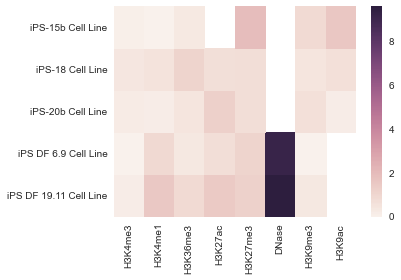

In [499]:
sns.heatmap(-np.log10(roadmap_peak_pvals))
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'roadmap_chip_seq_pval_heatmap.pdf'))

Given the enrichment in DNase peaks, I want to look at the enrichment for
other cell types' DNase peaks.

TODO: refactor below so I don't recompute every time.

In [532]:
fn = os.path.join(outdir, 'roadmap_dnase_res.tsv')
if not os.path.exists(fn):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    for n in files:
        url = ('http://egg2.wustl.edu/roadmap/data/byFileType/peaks/'
               'consolidated/narrowPeak/{}'.format(n))
        bt = pbt.BedTool(read_gzipped_text_url(url), from_string=True)
        bt = bt.sort()
        bt = bt.merge()
        oddsratio, p = calc_bed_enrichment(bt)
        roadmap_dnase_res.ix[n.split('-')[0], 'odds_ratio'] = oddsratio
        roadmap_dnase_res.ix[n.split('-')[0], 'pvalue'] = p
        print(n)
        roadmap_dnase_res.to_csv(fn, sep='\t')
else:
    roadmap_dnase_res = pd.read_table(fn, index_col=0)
roadmap_dnase_res.index = roadmap_ids[roadmap_dnase_res.index]

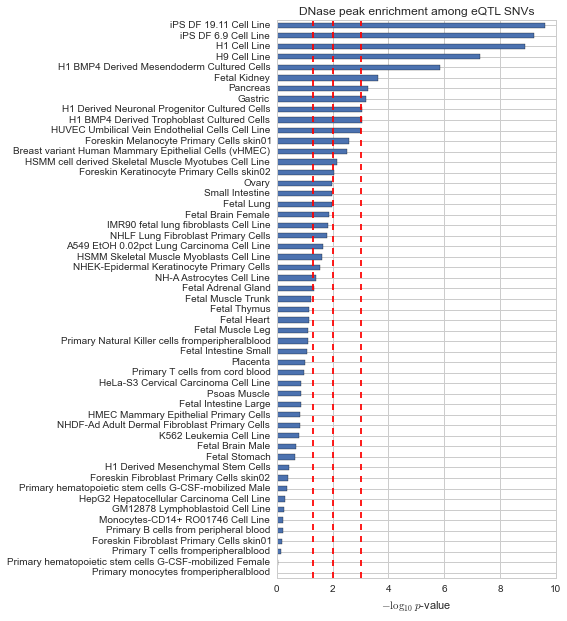

In [538]:
with sns.axes_style('whitegrid'):
    t = roadmap_dnase_res.sort(columns='pvalue', ascending=False)
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    #(-np.log10(t.pvalue.tail(30))).plot(kind='barh')
    (-np.log10(t.pvalue)).plot(kind='barh', ax=ax)
    ax.set_xlabel('$-\log_{10}$ $p$-value')
    ax.set_ylabel('')
    ya, yb = ax.get_ylim()
    ax.vlines(-np.log10(0.05), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.01), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.001), ya, yb, color='red', linestyle='--')
    ax.set_title('DNase peak enrichment among eQTL SNVs')
    #fig.tight_layout();

## ENCODE H1-hESC Transcription Factor Binding

I want to get all of the ENCODE DNase data. I need to keep track of

* the experiment accession (everything can be reconstructed from this)
* cell type
* organ
* life stage
* biosample treatment
* the narrowPeak accession
* the narrowPeak URL

In [ ]:
# Get DNase experiments.
fn = os.path.join(outdir, 'encode_dnase.tsv')
if not os.path.exists(fn):
    s = ('?type=experiment&assay_term_name=DNase-seq&assembly=hg19&'
         'files.file_type=bigBed%20narrowPeak')
    dnase_exp = pet.search(s, limit=1000)

    bad = []
    exp_acc = []
    cell_type = []
    peak_acc = []
    peak_url = []
    biosample_type = []
    for r in dnase_exp:
        r.fetch()
        keep = []
        for f in r.files:
            f.fetch()
            if f.file_type == 'bed narrowPeak':
                keep.append(f)
        if len(keep) > 0:
            cur_f = keep.pop()
            # It seems that some date_created attributes aren't formatted correctly.
            # I'll just end up taking a random bed file for these or the one that 
            # has the date formatted correctly.
            try:
                year, month, day = [int(x) for x in cur_f.date_created.split('-')]
                cur_date = dt.date(year, month, day)
            except ValueError:
                cur_date = dt.date(1900, 1, 1)
                bad.append(r.accession)
            while len(keep) > 0:
                new_f = keep.pop()
                try:
                    year, month, day = [int(x) for x in new_f.date_created.split('-')]
                    new_date = dt.date(year, month, day)
                except ValueError:
                    new_date = dt.date(1900, 1, 1)
                    bad.append(r.accession)
                if new_date > cur_date:
                    cur_f = new_f
                    cur_date = new_date
            exp_acc.append(r.accession)
            cell_type.append(r.biosample_term_name)
            biosample_type.append(r.biosample_type)
            peak_acc.append(cur_f.accession)
            peak_url.append('https://www.encodeproject.org{}'.format(cur_f.href))
        print(r.biosample_term_name)

    encode_dnase = pd.DataFrame({'cell_type': cell_type, 
                                 'narrowPeak_accession':peak_acc, 
                                 'narrowPeak_url': peak_url,
                                 'biosample_type': biosample_type},
                                index=exp_acc)
    encode_dnase.to_csv(fn, sep='\t')
else:
    encode_dnase = pd.read_table(fn, index_col=0)

In [513]:
fn = os.path.join(outdir, 'encode_dnase_res.tsv')
if not os.path.exists(fn):
    encode_dnase_res = pd.DataFrame(
        -1, index=encode_dnase.index, 
        columns=['odds_ratio', 'pvalue'])
    for i in encode_dnase.index:
        url = encode_dnase.ix[i, 'narrowPeak_url']
        bt = pbt.BedTool(read_gzipped_text_url(url), from_string=True)
        bt = bt.sort()
        bt = bt.merge()
        oddsratio, p = calc_bed_enrichment(bt)
        encode_dnase_res.ix[i, 'odds_ratio'] = oddsratio
        encode_dnase_res.ix[i, 'pvalue'] = p
        print(encode_dnase.ix[i, 'cell_type'])
else:
    encode_dnase_res = pd.read_table(fn, index_col=0)

Take away iPSC/stem cell DNase peaks. What tissues do we still see enrichments for?

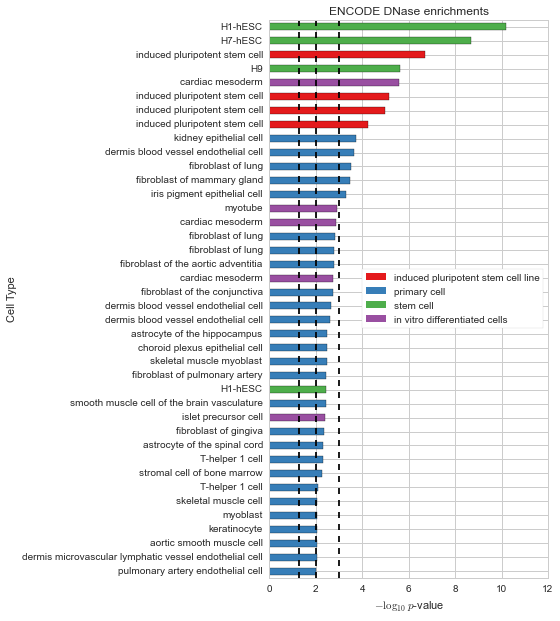

In [514]:
with sns.axes_style('whitegrid'):
    t = encode_dnase[encode_dnase.biosample_type != 'immortalized cell line']
    t = encode_dnase_res.ix[t.index].sort(columns='pvalue', ascending=False).tail(40)
    cdict = dict(zip(set(encode_dnase.ix[t.index, 'biosample_type']), sns.color_palette('Set1')))
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    c = [cdict[x] for x in encode_dnase.ix[t.index, 'biosample_type']]
    ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
    ax.set_ylabel('Cell Type')
    ax.set_xlabel('$-\log_{10}$ $p$-value')
    ax.set_title('ENCODE DNase enrichments')
    ya, yb = ax.get_ylim()
    ax.vlines(-np.log10(0.05), ya, yb, color='black', linestyle='--')
    ax.vlines(-np.log10(0.01), ya, yb, color='black', linestyle='--')
    ax.vlines(-np.log10(0.001), ya, yb, color='black', linestyle='--')
    ax.set_yticklabels(encode_dnase.ix[t.index, 'cell_type'])
    rects = []
    labels = []
    for k in cdict.keys():
        labels.append(k)
        r = Rectangle((0, 0), 0, 0, fc=cdict[k])
        rects.append(r)
    lgd = ax.legend(rects, labels, loc='center right',
                    frameon=True)#, prop={'size':8})
    for p in lgd.get_patches():
        p.set_linewidth(0)

I'd like to progammatically obtain all of the relevant ChIP-seq
datasets. I need to go into ChIP-seq experiment and find the 
narrowPeak files. I'll take one of the narrowPeaks that was most
recently released. Often there are two replicates but I think 
using one will be fine for now. If I want to use both, I probably
need to assume that both replicates were released on the same date
because it seems like it's hard to figure out which replicate a 
narrowPeak file is from.

I need to record 

* the experiment accession (everything can be reconstructed from this)
* the cell type
* the target
* the narrowPeak accession
* the narrowPeak URL

In [519]:
fn = os.path.join(outdir, 'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

In [277]:
# Get ChIP-seq experiments.
fn = os.path.join(outdir, 'encode_stem_cell_chip_seq.tsv')
if not os.path.exists(fn):
    s = ('?type=experiment&assay_term_name=ChIP-seq&'
         'replicates.library.biosample.donor.organism.scientific_name=Homo%20sapiens&'
         'replicates.library.biosample.biosample_type=stem%20cell&files.file_type=bed%20narrowPeak')
    chip_seq_exp = pet.search(s, limit=1000)

    exp_acc = []
    cell_type = []
    target = []
    target_type = []
    peak_acc = []
    peak_url = []
    for r in chip_seq_exp:
        r.fetch()
        keep = []
        for f in r.files:
            f.fetch()
            if f.file_type == 'bed narrowPeak':
                keep.append(f)
        if len(keep) > 0:
            cur_f = keep.pop()
            year, month, day = [int(x) for x in cur_f.date_created.split('-')]
            cur_date = dt.date(year, month, day)
            while len(keep) > 0:
                new_f = keep.pop()
                year, month, day = [int(x) for x in new_f.date_created.split('-')]
                new_date = dt.date(year, month, day)
                if new_date > cur_date:
                    cur_f = new_f
                    cur_date = new_date
            exp_acc.append(r.accession)
            cell_type.append(r.biosample_term_name)
            t = r.target
            t.fetch()
            target.append(t.label)
            target_type.append(', '.join(sorted(t.investigated_as)))
            peak_acc.append(cur_f.accession)
            peak_url.append('https://www.encodeproject.org{}'.format(cur_f.href))

    encode_chip_seq = pd.DataFrame({'cell_type': cell_type, 
                                    'target': target,
                                    'target_type': target_type,
                                    'narrowPeak_accession':peak_acc, 
                                    'narrowPeak_url': peak_url},
                                   index=exp_acc)
    encode_chip_seq.to_csv(fn, sep='\t')
else:
    encode_chip_seq = pd.read_table(fn, index_col=0)

In [517]:
fn = os.path.join(outdir, 'encode_stem_cell_chip_seq_res.tsv')
if not os.path.exists(fn):
    encode_chip_seq_res = pd.DataFrame(
        -1, index=encode_chip_seq.index, 
        columns=['odds_ratio', 'pvalue'])
    for i in encode_chip_seq.index:
        url = encode_chip_seq.ix[i, 'narrowPeak_url']
        bt = pbt.BedTool(read_gzipped_text_url(url), from_string=True)
        bt = bt.sort()
        bt = bt.merge()
        oddsratio, p = calc_bed_enrichment(bt)
        encode_chip_seq_res.ix[i, 'odds_ratio'] = oddsratio
        encode_chip_seq_res.ix[i, 'pvalue'] = p
    encode_chip_seq_res.to_csv(fn, sep='\t')
else:
    encode_chip_seq_res = pd.read_table(fn, index_col=0)

In [522]:
encode_chip_seq_res[encode_chip_seq_res.odds_ratio < 1]

,odds_ratio,pvalue,target
experiment_accession,,,
ENCSR000EUQ,0.000000,1.000000,SUZ12
ENCSR000EBY,0.777405,1.000000,MYC
ENCSR000EBX,0.860695,1.000000,BRCA1
ENCSR000DST,0.799696,0.431466,H3K27me3
ENCSR000DSS,0.934124,1.000000,H3K36me3
ENCSR000DSR,0.934011,0.786421,H3K4me3
ENCSR000DLI,0.000000,1.000000,MYC
ENCSR000BJW,0.000000,1.000000,RXRA
ENCSR000BIQ,0.824038,1.000000,SIX5


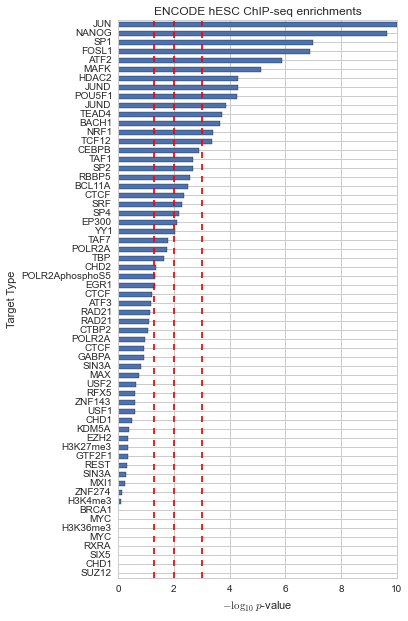

In [518]:
with sns.axes_style('whitegrid'):
    t = encode_chip_seq_res.sort(columns='pvalue', ascending=False)
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax)
    ax.set_ylabel('Target Type')
    ax.set_xlabel('$-\log_{10}$ $p$-value')
    ax.set_title('ENCODE hESC ChIP-seq enrichments')
    ya, yb = ax.get_ylim()
    ax.vlines(-np.log10(0.05), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.01), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.001), ya, yb, color='red', linestyle='--')
    ax.set_yticklabels(t.target);